In [3]:
!cd ../

In [4]:
# import packages
import os
import random
import math
import time

import numpy
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

In [8]:
# load data
path_do_data = '../../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

In [63]:
!pip install torchtext==0.2.3

Processing c:\users\asus\appdata\local\pip\cache\wheels\b6\3d\02\1f6c5be7904ae196115843d2ff2e81a9f50b7a7d4ecdfea14a\torchtext-0.2.3-py3-none-any.whl
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.4.0
    Uninstalling torchtext-0.4.0:
      Successfully uninstalled torchtext-0.4.0


In [11]:
# The structure of the file: src_sentence \t trg_sentence
with open(path_do_data, encoding="utf-8") as file:
    for line in file:
        line = line
        print(line)
        break

Cordelia Hotel is situated in Tbilisi, a 3-minute walk away from Saint Trinity Church.	Отель Cordelia расположен в Тбилиси, в 3 минутах ходьбы от Свято-Троицкого собора.



In [14]:
test_src, test_trg = line.split("\t")
print(f"test_src: {test_src}")
print(f"test_trg: {test_trg}")

test_src: Cordelia Hotel is situated in Tbilisi, a 3-minute walk away from Saint Trinity Church.
test_trg: Отель Cordelia расположен в Тбилиси, в 3 минутах ходьбы от Свято-Троицкого собора.



In [18]:
# make train, valid, test split
tokenizer_words = WordPunctTokenizer()
def tokenize(text):
    return tokenizer_words.tokenize(text.lower())
print(tokenize(test_src))
print(tokenize(test_trg))

['cordelia', 'hotel', 'is', 'situated', 'in', 'tbilisi', ',', 'a', '3', '-', 'minute', 'walk', 'away', 'from', 'saint', 'trinity', 'church', '.']
['отель', 'cordelia', 'расположен', 'в', 'тбилиси', ',', 'в', '3', 'минутах', 'ходьбы', 'от', 'свято', '-', 'троицкого', 'собора', '.']


In [47]:
SRC = Field(tokenize=tokenize,
            init_token='<sos>',
            eos_token='<eos>',
            lower = True)

TRG = Field(tokenize=tokenize,
            init_token='<sos>',
            eos_token='<eos>',
            lower = True)

dataset = torchtext.data.TabularDataset(path=path_do_data,
                                     format="tsv",
                                     fields=[("trg", TRG), ("src", SRC)],
                                     )
train_data, test_data, valid_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [48]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 7500
Number of testing examples: 2500


In [49]:
test_example = vars(train_data.examples[0])
print(f"test_example src: {test_example['src']}")
print(f"test_example trg: {test_example['trg']}")

test_example src: ['к', 'услугам', 'гостей', 'место', 'для', 'костра', 'и', 'принадлежности', 'для', 'барбекю', '.']
test_example trg: ['there', 'is', 'a', 'bonfire', 'spot', 'and', 'barbecue', 'facilities', '.']


In [51]:
# Build the vocab for src and trg

SRC.build_vocab(train_data, min_freq=3)
TRG.build_vocab(train_data, min_freq=3)

In [52]:
print(f"The number of unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"The number of unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

The number of unique tokens in source (ru) vocabulary: 9262
The number of unique tokens in target (en) vocabulary: 6686


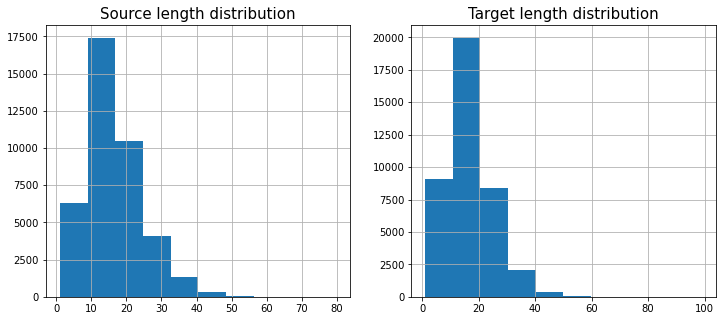

In [57]:
# length distribution
src_length = list(map(len, [vars(x)['src'] for x in train_data]))
trg_length = list(map(len, [vars(x)['trg'] for x in train_data]))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.grid()
plt.title("Source length distribution", size=15)
plt.hist(src_length);

plt.subplot(1, 2, 2)
plt.grid()
plt.title("Target length distribution", size=15)
plt.hist(trg_length);

In [59]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def _len_sort_key(x):
    return len(x.src)

batch_size=128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits((train_data, valid_data, test_data),
                                                                batch_size = batch_size,
                                                                sort_key=_len_sort_key,
                                                                device=device)

In [60]:
for batch in train_iterator:
    (x, y), _ = batch
    break
print(x.shape)
print(y.shape)

RuntimeError: Invalid device, must be cuda device